# Ordinary Least Squares on magnet challenge dataset

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.integrate import trapezoid

# Read Dataset

In [2]:
filepath = '/home/nikolasf/Dokumente/01_git/30_Python/MC_UPB/data/input/processed'
material_name = 'ten_materials'
ds = pd.read_pickle(f'{filepath}/{material_name}.pkl.gz')

# Initial edit dataset

In [3]:

ds = ds.drop(columns=[c for c in ds if c.startswith("H_t")])
#ds = ds.query('temp == 25')

# add the saturation flux density. Data from datasheets.
ds.loc[ds['material'] == '3C90', 'b_sat_25'] = 0.47
ds.loc[ds['material'] == '3C94', 'b_sat_25'] = 0.47
ds.loc[ds['material'] == '3E6', 'b_sat_25'] = 0.46
ds.loc[ds['material'] == '3F4', 'b_sat_25'] = 0.41
ds.loc[ds['material'] == '77', 'b_sat_25'] = 0.51
ds.loc[ds['material'] == '78', 'b_sat_25'] = 0.48
ds.loc[ds['material'] == 'N27', 'b_sat_25'] = 0.50
ds.loc[ds['material'] == 'N30', 'b_sat_25'] = 0.38
ds.loc[ds['material'] == 'N49', 'b_sat_25'] = 0.49
ds.loc[ds['material'] == 'N87', 'b_sat_25'] = 0.49


print(ds['ploss'])
ds['ploss'] = np.log(ds['ploss'])
ds['freq'] = np.log(ds['freq'])

print(ds['ploss'])

# print(ds)

0           2319.444340
1           3191.235893
2           4341.086142
3           5795.359190
4           7813.691725
              ...      
186742     68121.464932
186743     85924.743654
186744    108411.839417
186745    135853.384296
186746    171849.522231
Name: ploss, Length: 186747, dtype: float64
0          7.749083
1          8.068164
2          8.375880
3          8.664813
4          8.963633
            ...    
186742    11.129048
186743    11.361227
186744    11.593693
186745    11.819332
186746    12.054375
Name: ploss, Length: 186747, dtype: float64


### Adapted Wilhelm example

In [9]:
"""Run linear regression with regularization training"""
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, VotingRegressor, ExtraTreesRegressor
from tqdm import tqdm
from pprint import pprint
from utils.experiments import get_stratified_fold_indices, PROC_SOURCE
from utils.metrics import calculate_metrics
import xgboost as xgb

pd.set_option("display.max_columns", None)


def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 800)
    # 429 is best
    print(f'{n_estimators = }')
    criterion = trial.suggest_categorical('criterion', ['squared_error'])
    print(f"{criterion = }")
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
    # 0.12 is best
    print(f"{learning_rate = }")
    
    exp_log = {}
    for material_lbl, mat_df in tqdm(ds.groupby("material"), desc="Train across materials"):
        full_b = mat_df.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy()
        dbdt = full_b[:, 1:] - full_b[:, :-1]
        mat_df = mat_df.reset_index(drop=True)

        x_vec = np.linspace(0, 1023, 1024)
        b_vec = []
        for value in x_vec:
            b_vec.append(f'B_t_{int(value)}')
        mat_df["b"] = mat_df[b_vec].values.tolist()
        x_vec = None
        b_vec = None
        mat_df['delta_b'] = mat_df['b'].map(lambda x: np.max(x) - np.min(x))

        # figure out integral_part 
        mat_df["time_s"] = mat_df["freq"].map(lambda x: np.linspace(0, 1/x, 1024))

        # derivation
        # according to https://im-coder.com/zweite-ableitung-in-python-scipy-numpy-pandas.html
        mat_df["fitted_function"] = mat_df.apply(lambda x: UnivariateSpline(x["time_s"], x["b"], s=0, k=4), axis=1)
        mat_df["amplitude_2nd_derivation"] = mat_df["fitted_function"].apply(lambda x: x.derivative(n=2))
        mat_df["integrated_function"] = mat_df.apply(lambda x: trapezoid(np.abs(x["amplitude_2nd_derivation"](x["time_s"])), x["time_s"]), axis=1)     

        mat_df["integral_part"] = mat_df["integrated_function"] / mat_df["delta_b"]

        

        # cross validation 'kfold'
        kfold_lbls = get_stratified_fold_indices(mat_df, 4)
        mat_df_proc = mat_df.assign(
            kfold=kfold_lbls,
            # integral_part=mat_df['integral_part'],
            #delta_b=mat_df['delta_b'],
            #b_sat=mat_df['b_sat_25'],
            db_bsat_1 = mat_df['delta_b'] / mat_df['b_sat_25'],
            db_bsat_2 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 2,
            db_bsat_3 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 3,
            db_bsat_4 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 4,
            db_bsat_5 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 5,
            db_bsat_6 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 6,
            temp_square = mat_df['temp'] ** 2,
            t2 = (mat_df['integral_part'] ** (-1)) / 2,
            #t3 = -(mat_df['integral_part'] ** (-2)) / 6,
            #t4 = ( 3 * mat_df['integral_part'] ** (-2) + 2 * mat_df['integral_part'] ** (-3)) / 24,
            #mean_abs_dbdt=np.mean(np.abs(mat_df["delta_b"])),
            # more features imaginable (count of spikes e.g.)
        ).drop(
            columns=[c for c in mat_df if c.startswith("B_t_")] + ["material"] + ['b'] + ['time_s'] + ['fitted_function'] +['amplitude_2nd_derivation'] + ['integrated_function'] + ['b_sat_25']
        )  # drop B curve

        # training result container
        results_df = mat_df_proc.loc[:, ["ploss", "kfold"]].assign(pred=0)
        x_cols = [c for c in mat_df_proc if c not in ["ploss", "kfold"]]
        print(x_cols)
        for kfold_lbl, test_fold_df in mat_df_proc.groupby("kfold"):
            train_fold_df = (
                mat_df_proc.query("kfold != @kfold_lbl")
                .reset_index(drop=True)
                .drop(columns="kfold")
            )
            assert len(train_fold_df) > 0, "empty dataframe error"
            y = train_fold_df.pop("ploss")
            X = train_fold_df.loc[:, x_cols]

            #mdl = GradientBoostingRegressor(n_estimators=n_estimators, criterion=criterion, learning_rate=learning_rate) # GradientBoostingRegressor() # HistGradientBoostingRegressor() # RandomForestRegressor(n_estimators = 100) #LinearRegression() # Ridge()  # 
            mdl = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate) #, max_depth=max_depth)
            mdl.fit(X.to_numpy(), y.to_numpy())
            pred = mdl.predict(test_fold_df.loc[:, x_cols].to_numpy())
            results_df.loc[results_df.kfold == kfold_lbl, "pred"] = pred

        # book keeping
        exp_log[material_lbl] = calculate_metrics(
            np.exp(results_df.loc[:, "pred"]), np.exp(results_df.loc[:, "ploss"])
        )
    print(mdl.__class__.__name__)
    print(f"{n_estimators = }")
    print(f"{learning_rate = }")
    print(mdl.feature_importances_)
    
    print("Overall Score")
    score = pd.DataFrame(exp_log).T
    print(score)

    added_avg_abs_rel_err = score['avg-abs-rel-err'].sum()
    print('sum error')
    print(added_avg_abs_rel_err)
    
    # feature importances
    feat_importances = pd.Series(mdl.feature_importances_, index=x_cols)
    feat_importances.nlargest(20).plot(kind='barh')
    
    return added_avg_abs_rel_err

In [5]:
# print(mdl.features_importances_)


### Run objective function single

In [6]:
# objective()

### Run objective function in a hyperparameter optimization loop

[I 2023-09-05 09:28:50,113] A new study created in memory with name: no-name-d3c574e9-a7f1-4c75-b26f-34c6ed18b8ab


n_estimators = 283
criterion = 'squared_error'
learning_rate = 0.4611984857942241


Train across materials:   0%|          | 0/10 [00:00<?, ?it/s]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  10%|█         | 1/10 [01:43<15:31, 103.45s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  20%|██        | 2/10 [04:54<20:38, 154.80s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  30%|███       | 3/10 [05:13<10:50, 92.92s/it] 

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  40%|████      | 4/10 [05:35<06:28, 64.79s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  50%|█████     | 5/10 [06:12<04:33, 54.76s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  60%|██████    | 6/10 [06:44<03:08, 47.13s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  70%|███████   | 7/10 [07:14<02:05, 41.67s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  80%|████████  | 8/10 [07:40<01:13, 36.57s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  90%|█████████ | 9/10 [08:11<00:34, 34.71s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials: 100%|██████████| 10/10 [14:37<00:00, 87.72s/it] 


XGBRegressor
n_estimators = 283
learning_rate = 0.4611984857942241
[8.3938025e-02 1.5201190e-02 2.5061741e-01 6.7338264e-03 6.4303976e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.5479772e-04 0.0000000e+00
 0.0000000e+00 3.1498482e-04]
Overall Score
               mse           mae  avg-abs-rel-err  percentile_5_rel_err  \
3C90  3.991364e+08   8614.333195         0.078243              0.004614   
3C94  9.544469e+08  13385.412128         0.071714              0.004823   
3E6   4.717489e+09  32287.303634         0.063275              0.003459   
3F4   3.775394e+08   6736.041105         0.047321              0.002376   
77    1.116504e+09  14370.323874         0.074300              0.004516   
78    8.125399e+08  11989.456117         0.071617              0.004320   
N27   1.538237e+09  15871.247138         0.066071              0.003872   
N30   5.677884e+09  30071.026051         0.062543              0.003951   
N49   3.089757e+09  23611.936561         0.067554              0.003559 

[I 2023-09-05 09:43:28,204] Trial 0 finished with value: 0.6661121146545167 and parameters: {'n_estimators': 283, 'criterion': 'squared_error', 'learning_rate': 0.4611984857942241}. Best is trial 0 with value: 0.6661121146545167.


n_estimators = 529
criterion = 'squared_error'
learning_rate = 0.23101623916474265


Train across materials:   0%|          | 0/10 [00:00<?, ?it/s]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  10%|█         | 1/10 [03:16<29:30, 196.76s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  20%|██        | 2/10 [10:22<44:12, 331.61s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  30%|███       | 3/10 [10:53<22:40, 194.30s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  40%|████      | 4/10 [11:22<12:54, 129.00s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  50%|█████     | 5/10 [12:09<08:17, 99.48s/it] 

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  60%|██████    | 6/10 [12:57<05:27, 81.86s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  70%|███████   | 7/10 [13:44<03:31, 70.64s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  80%|████████  | 8/10 [14:22<02:00, 60.13s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  90%|█████████ | 9/10 [14:58<00:52, 52.49s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials: 100%|██████████| 10/10 [18:42<00:00, 112.27s/it]


XGBRegressor
n_estimators = 529
learning_rate = 0.23101623916474265
[2.3837754e-01 3.6839817e-02 7.0593351e-01 1.6372107e-02 3.8286552e-04
 8.3763874e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.2565590e-03]
Overall Score
               mse           mae  avg-abs-rel-err  percentile_5_rel_err  \
3C90  2.726518e+08   7237.511423         0.067498              0.003843   
3C94  6.487588e+08  11144.011492         0.061201              0.004019   
3E6   2.910521e+09  24991.920005         0.048529              0.002701   
3F4   2.564645e+08   5889.457518         0.040236              0.002331   
77    7.097493e+08  11608.374067         0.061877              0.003497   
78    4.443441e+08   9138.868613         0.058813              0.003454   
N27   8.159484e+08  11949.960641         0.051535              0.003179   
N30   4.073811e+09  24151.355334         0.048882              0.002795   
N49   1.749761e+09  18440.615133         0.054261              0.002734

[I 2023-09-05 10:02:11,805] Trial 1 finished with value: 0.5465440776696455 and parameters: {'n_estimators': 529, 'criterion': 'squared_error', 'learning_rate': 0.23101623916474265}. Best is trial 1 with value: 0.5465440776696455.


n_estimators = 513
criterion = 'squared_error'
learning_rate = 0.14522505218104106


Train across materials:   0%|          | 0/10 [00:00<?, ?it/s]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  10%|█         | 1/10 [03:25<30:50, 205.61s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  20%|██        | 2/10 [06:52<27:30, 206.37s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  30%|███       | 3/10 [07:38<15:33, 133.33s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  40%|████      | 4/10 [08:18<09:36, 96.16s/it] 

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  50%|█████     | 5/10 [09:26<07:09, 85.99s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  60%|██████    | 6/10 [10:27<05:10, 77.70s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  70%|███████   | 7/10 [11:31<03:39, 73.15s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  80%|████████  | 8/10 [12:29<02:16, 68.34s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials:  90%|█████████ | 9/10 [13:20<01:03, 63.06s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2']


Train across materials: 100%|██████████| 10/10 [16:53<00:00, 101.34s/it]


XGBRegressor
n_estimators = 513
learning_rate = 0.14522505218104106
[0.22773388 0.04101413 0.7153157  0.0159363  0.         0.
 0.         0.         0.         0.         0.         0.        ]
Overall Score
               mse           mae  avg-abs-rel-err  percentile_5_rel_err  \
3C90  2.751059e+08   7295.462680         0.067158              0.003886   
3C94  6.377854e+08  10980.569991         0.060020              0.003760   
3E6   2.527947e+09  23291.419084         0.045228              0.002712   
3F4   2.250660e+08   5389.439103         0.037689              0.001915   
77    6.453330e+08  10847.896646         0.058077              0.003343   
78    4.381725e+08   8839.829013         0.057541              0.003526   
N27   7.447922e+08  11438.951256         0.048921              0.002981   
N30   3.876544e+09  22953.150317         0.045843              0.002685   
N49   1.917061e+09  18619.374567         0.053745              0.002683   
N87   1.954815e+08   6206.094076         

[I 2023-09-05 10:19:06,085] Trial 2 finished with value: 0.5264976470439371 and parameters: {'n_estimators': 513, 'criterion': 'squared_error', 'learning_rate': 0.14522505218104106}. Best is trial 2 with value: 0.5264976470439371.


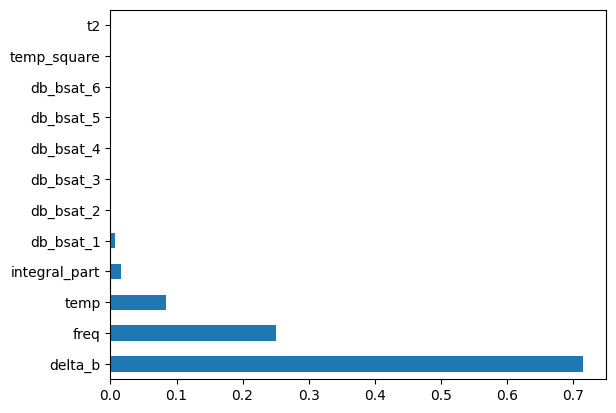

In [10]:
import optuna

import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).


plt.

study = optuna.create_study(direction="minimize")
stud
y.optimize(objective, n_trials=3, n_jobs=1)
#print(study.best_trial)